In [1]:
import pickle
import pandas as pd
import partial_dependence as pdp_plot
import numpy as np
import matplotlib.pyplot as plt

In [2]:
root_sentiero = "example_data"
df_test = pd.read_csv(root_sentiero+"/test.csv")

ground_truth_column = "label"
features = [x for x in list(df_test.columns) if x not in [ground_truth_column]]

df_test = df_test[features]

name = "rf"
fileobj = open( root_sentiero+"/"+name+".pkl", "rb" )

pickle_model = pickle.load( fileobj )

chosen_feature = "alcohol"
ch_num_samples = 100
ch_clust_number = 10
ch_scale = np.array(pickle_model["scale"])
ch_shift = np.array(pickle_model["shift"])
model = pickle_model["model"]
labels_name = ["good\nwine","bad\nwine"]
labels_focus = labels_name[0]

In [3]:
wine_pdp_plot_RF = pdp_plot.PartialDependence(df_test,
                                              model,
                                              labels_name,
                                              labels_focus,
                                              ch_num_samples,
                                              ch_scale,
                                              ch_shift)

In [4]:
curves = wine_pdp_plot_RF.pdp(chosen_feature)


In [5]:
full_curves = curves.copy()

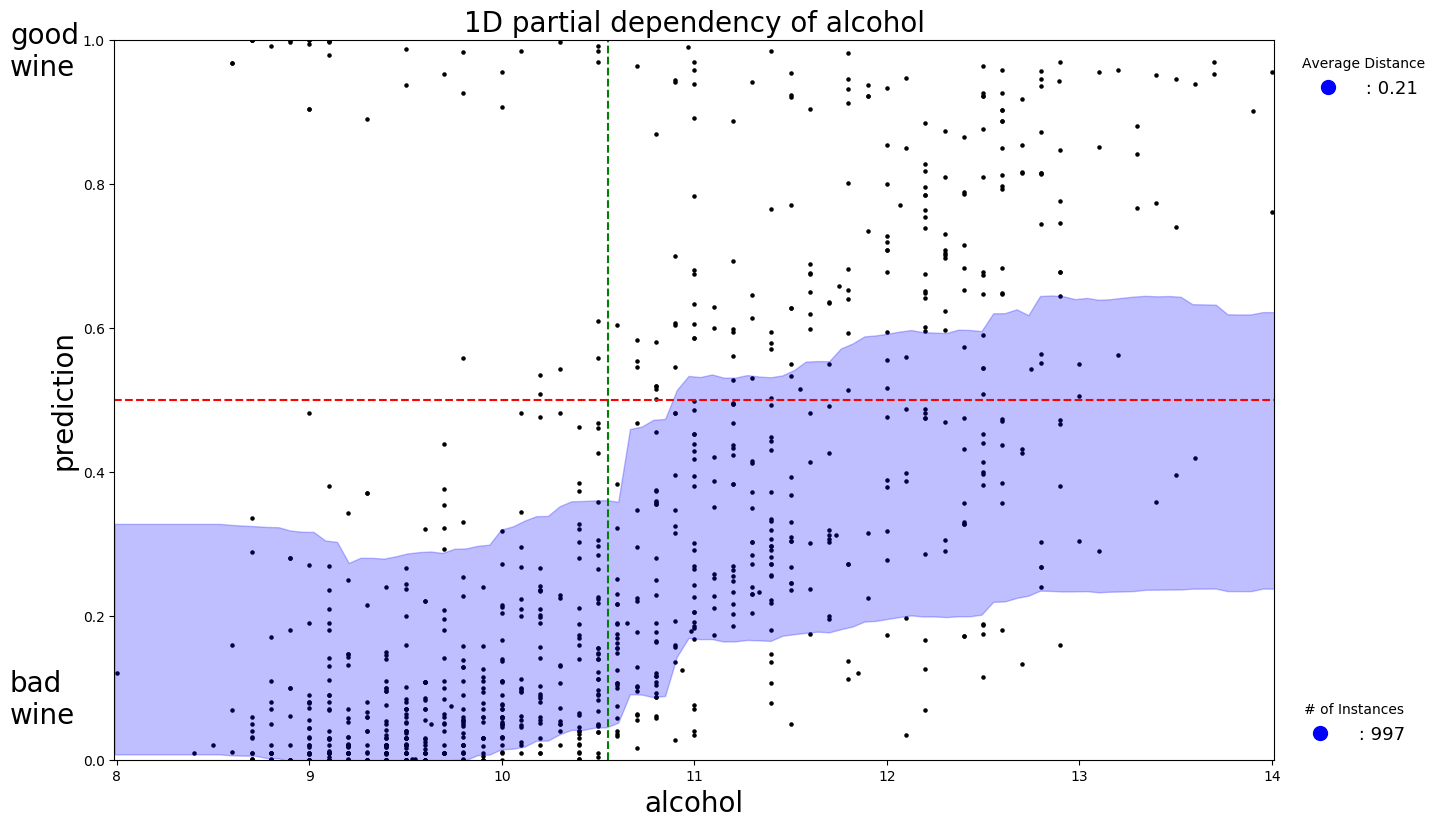

In [6]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = False, plot_full_curves = False)


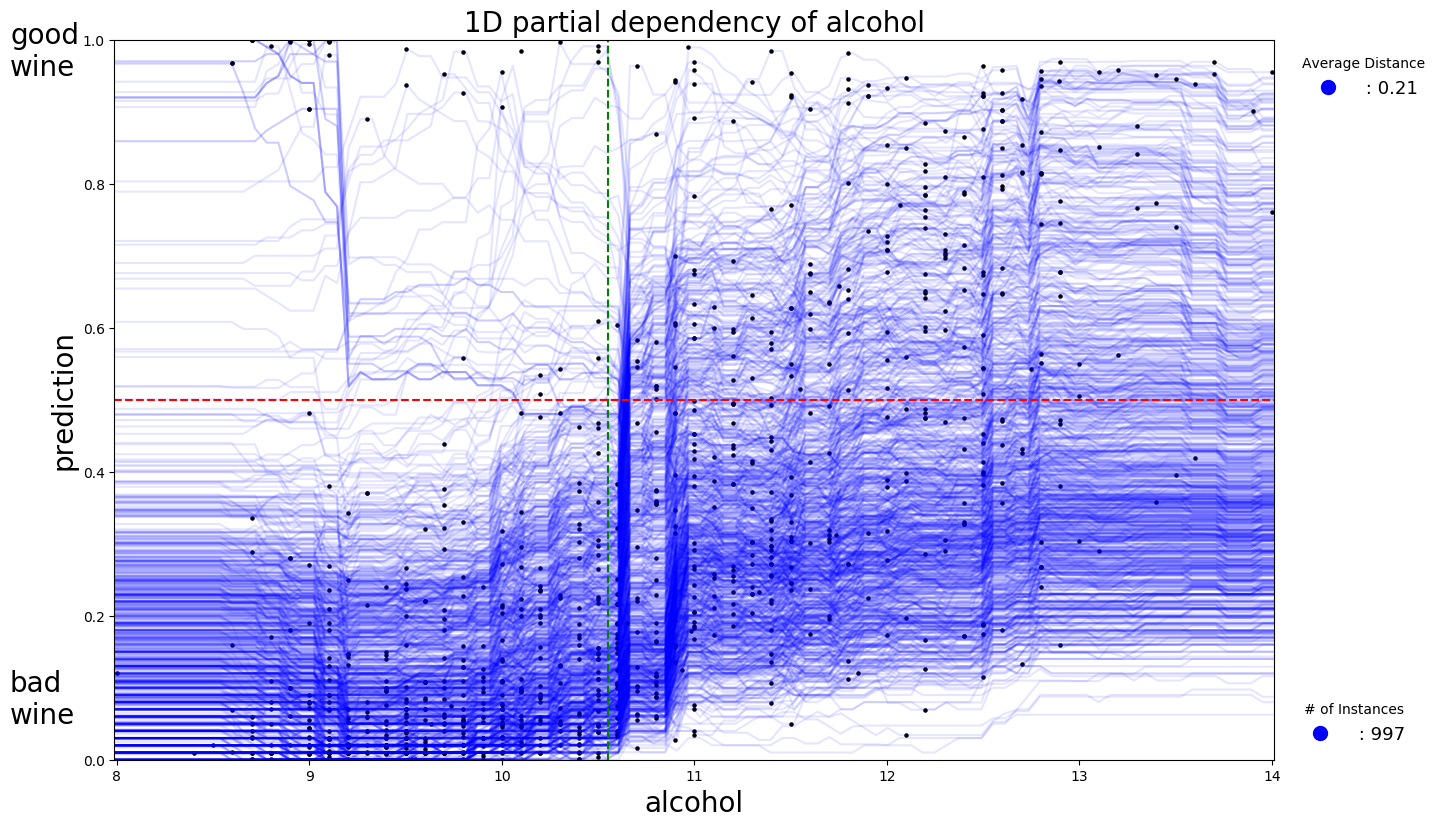

In [7]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = False, plot_full_curves = True)

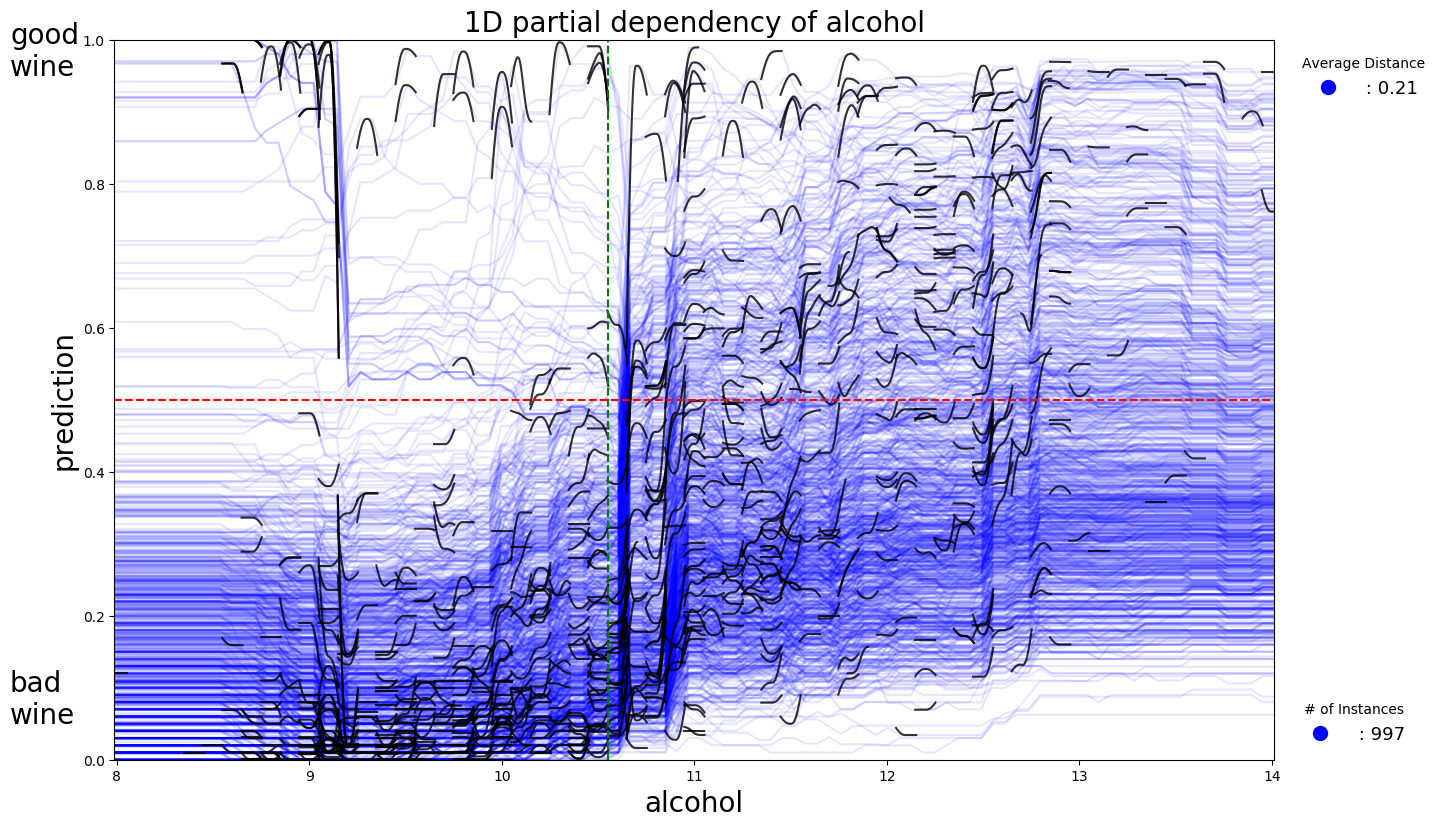

In [8]:
#plotting
wine_pdp_plot_RF.plot(full_curves,local_curves = True, plot_full_curves = True)

In [9]:
# computing clustering using deafult rmse distance
curves_list_RF = wine_pdp_plot_RF.compute_clusters(curves,ch_clust_number)

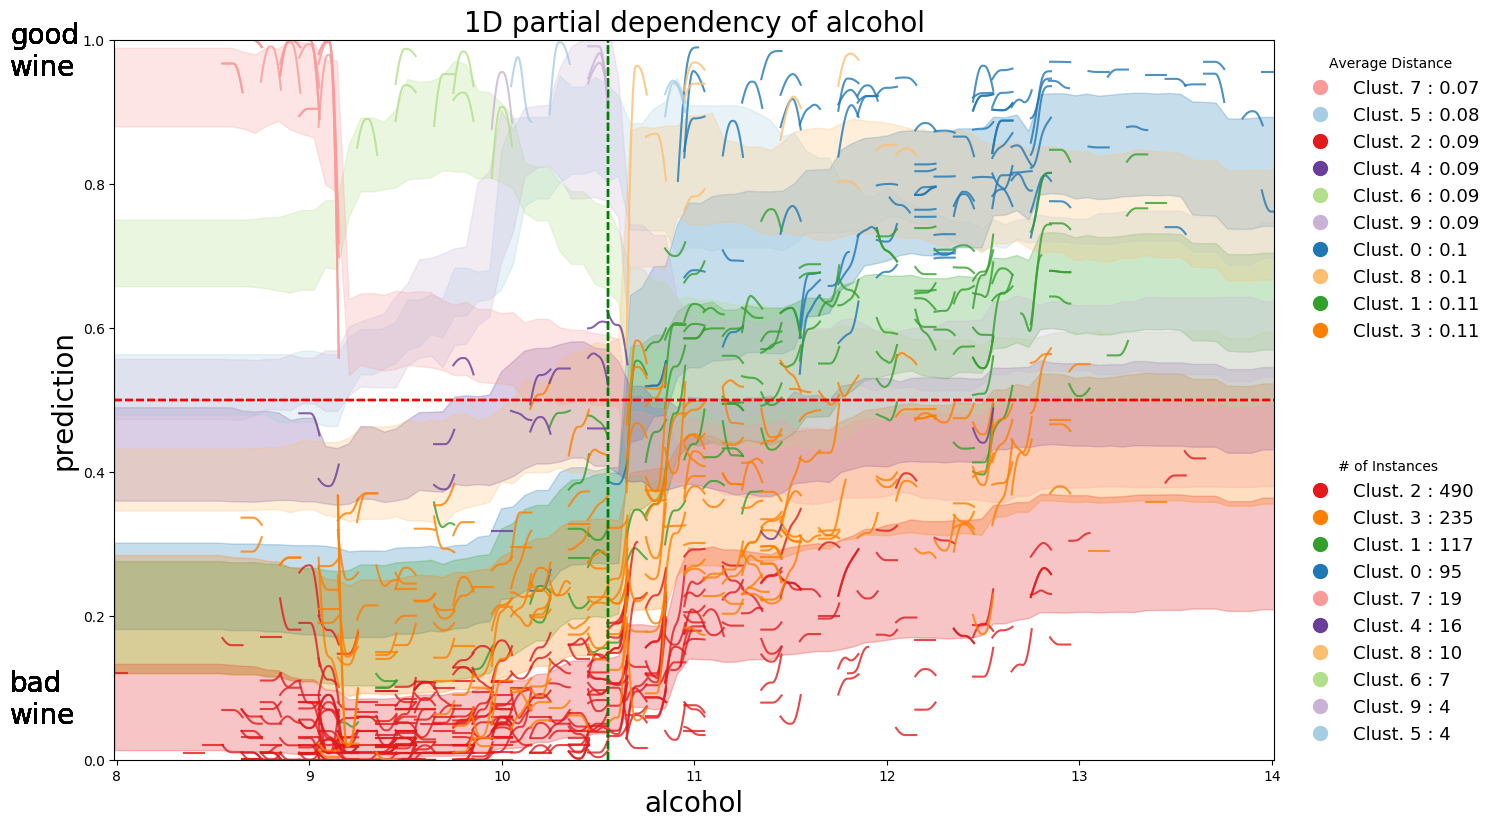

In [10]:
wine_pdp_plot_RF.plot(curves_list_RF)

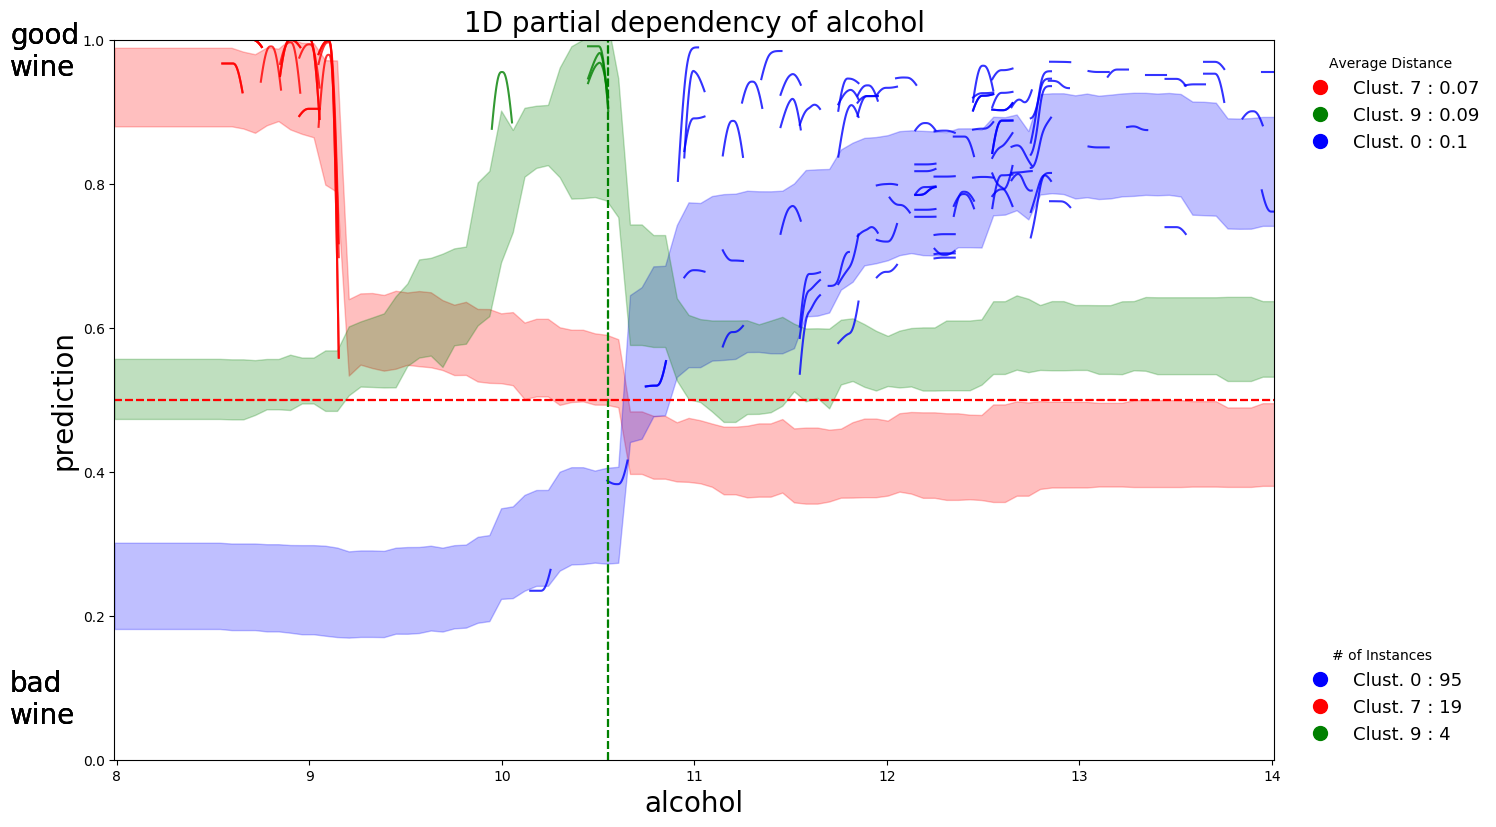

In [11]:
cluster_7 = curves_list_RF[7]
cluster_0 = curves_list_RF[0]
cluster_9 = curves_list_RF[9]

fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

wine_pdp_plot_RF.plot(cluster_7,
                   color_plot="red", 
                   plot_object=ax)

wine_pdp_plot_RF.plot(cluster_0,
                   color_plot="blue", 
                   plot_object=ax)

wine_pdp_plot_RF.plot(cluster_9,
                   color_plot="green", 
                   plot_object=ax)

plt.show()
fig.savefig("plot_" + chosen_feature + ".png")
plt.close("all")

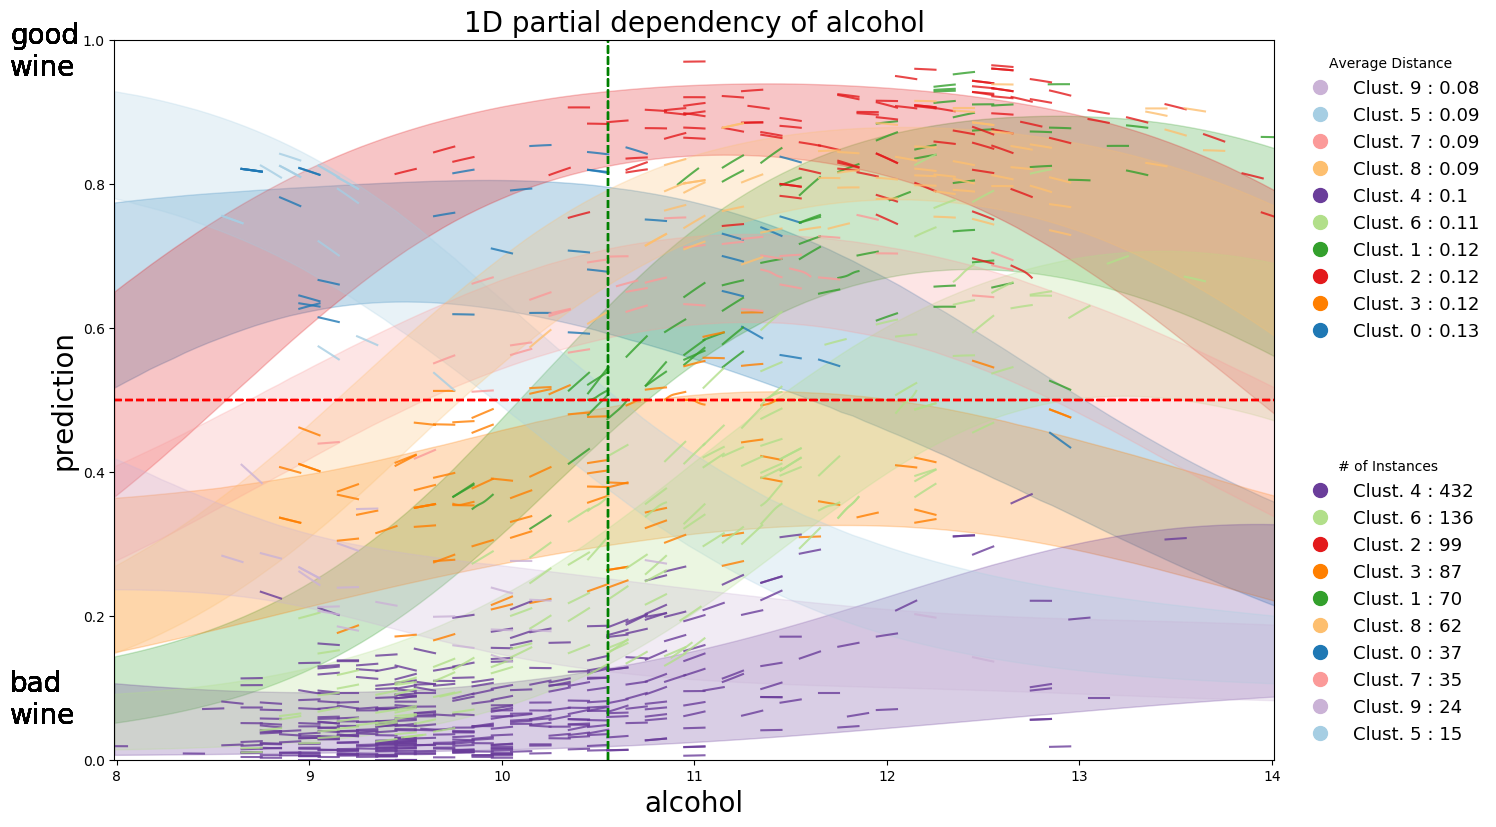

In [12]:
name_SVM = "svc"
fileobj = open( root_sentiero+"/"+name_SVM+".pkl", "rb" )

pickle_model_SVM = pickle.load( fileobj )

ch_scale_SVM = np.array(pickle_model_SVM["scale"])
ch_shift_SVM = np.array(pickle_model_SVM["shift"])
model_SVM = pickle_model_SVM["model"]



wine_pdp_plot_SVM = pdp_plot.PartialDependence(df_test,
                  model_SVM,
                  labels_name,
                  labels_focus,
                  ch_num_samples,
                  ch_scale_SVM,
                  ch_shift_SVM)

curves = wine_pdp_plot_SVM.pdp(chosen_feature)
curves_list_SVM = wine_pdp_plot_SVM.compute_clusters(curves,ch_clust_number)
wine_pdp_plot_SVM.plot(curves_list_SVM)


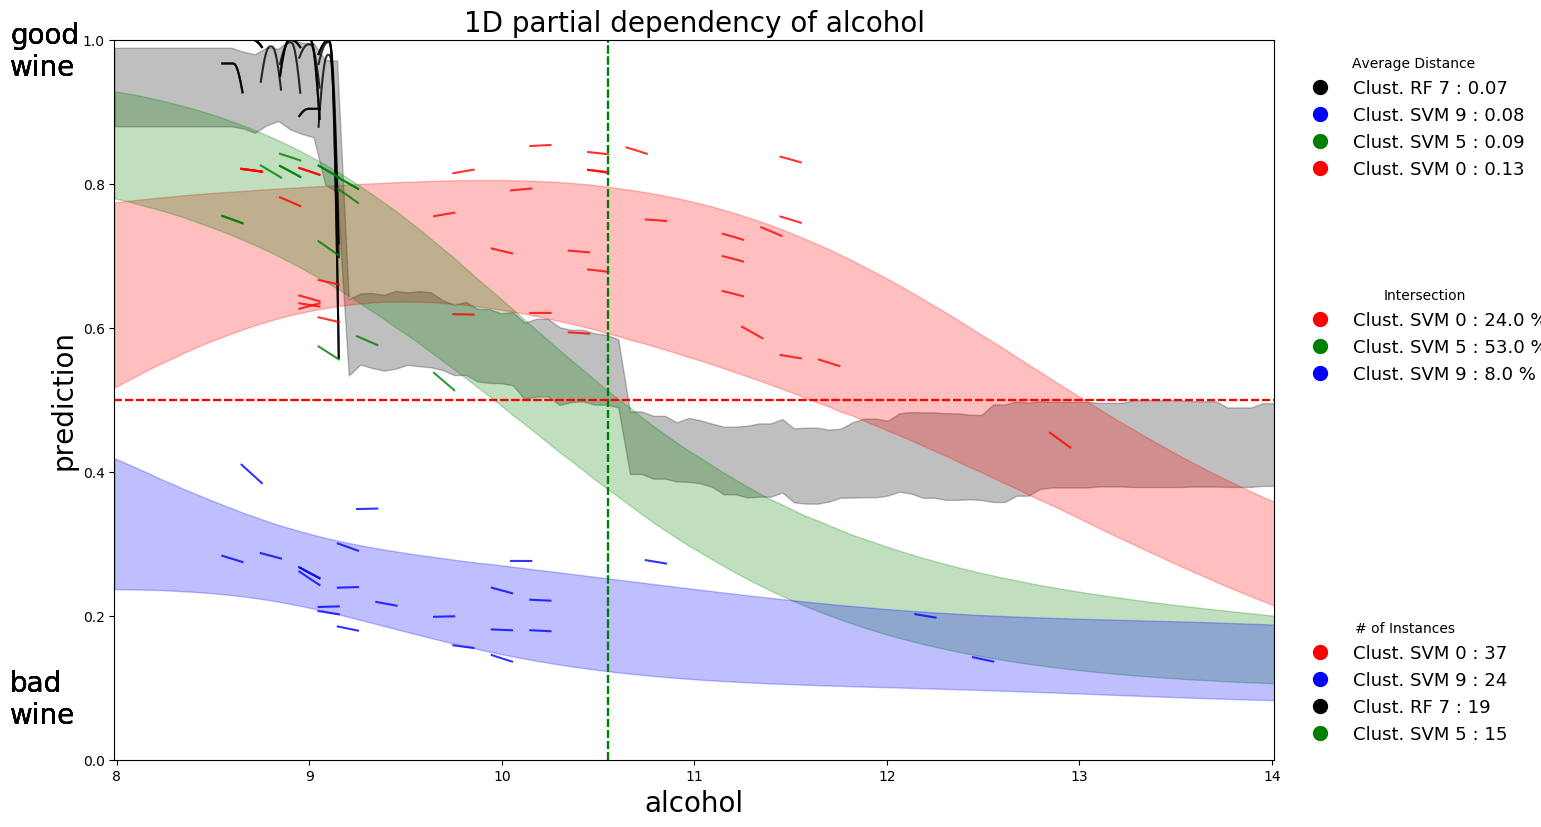

In [13]:
cluster_7_RF = curves_list_RF[7]

set_RF = set(cluster_7_RF[1].get_ixs())

clusters_SVM_related = []
intrs_values = []

#finding clusters from the SVM with instances in common with cluster 7 from RF
for cluster_SVM in curves_list_SVM:
    set_SVM = set(cluster_SVM[1].get_ixs())
    intrs_val = len(set_RF.intersection(set_SVM))
    string_int = str(np.around(intrs_val/len(set_SVM),decimals=2)*100)+ " %"
    
    if intrs_val!=0:
        string_label = "SVM "+str(cluster_SVM[0])
        cluster_SVM = (string_label,cluster_SVM[1])
        clusters_SVM_related.append(cluster_SVM)
        intrs_values.append("Clust. "+string_label+" : "+string_int)

fig, ax = plt.subplots(figsize=(16, 9), dpi=100)

#setting label
cluster_7_RF = ("RF "+str(cluster_7_RF[0]),cluster_7_RF[1])

wine_pdp_plot_RF.plot(cluster_7_RF,
                      color_plot="black", 
                      plot_object=ax)

color_legend = ["r","g","b"]

wine_pdp_plot_SVM.plot(clusters_SVM_related,
                       color_plot=color_legend,
                       plot_object=ax)

#adding a legend to read how many instances each sluter from the SVM is sharing with cluster_7_RF
from matplotlib.legend import Legend

patches = [ plt.plot([], [], marker="o", ms=10, ls="", mec=None, color=color_legend[i], 
            label="{:s}".format(intrs_values[i]))[0] for i in range(len(intrs_values)) ] 

int_legend = Legend(ax, labels=intrs_values, handles=patches, bbox_to_anchor=(1.01,0.5),
                          loc="lower left", ncol=1, facecolor="#d3d3d3", 
                          numpoints=1, fontsize=13,frameon=False,
                          title = "Intersection")
ax.add_artist(int_legend)

plt.show()
fig.savefig("plot_" + chosen_feature + ".png")
plt.close("all")

In [14]:
#using all possible default arguments
# if scale and shift are default = None 
# then we have to provide directly the normalized data 

df_test_matrix = (df_test.as_matrix() + ch_shift)*ch_scale
normalized_df = pd.DataFrame(df_test_matrix)
normalized_df.columns = df_test.columns



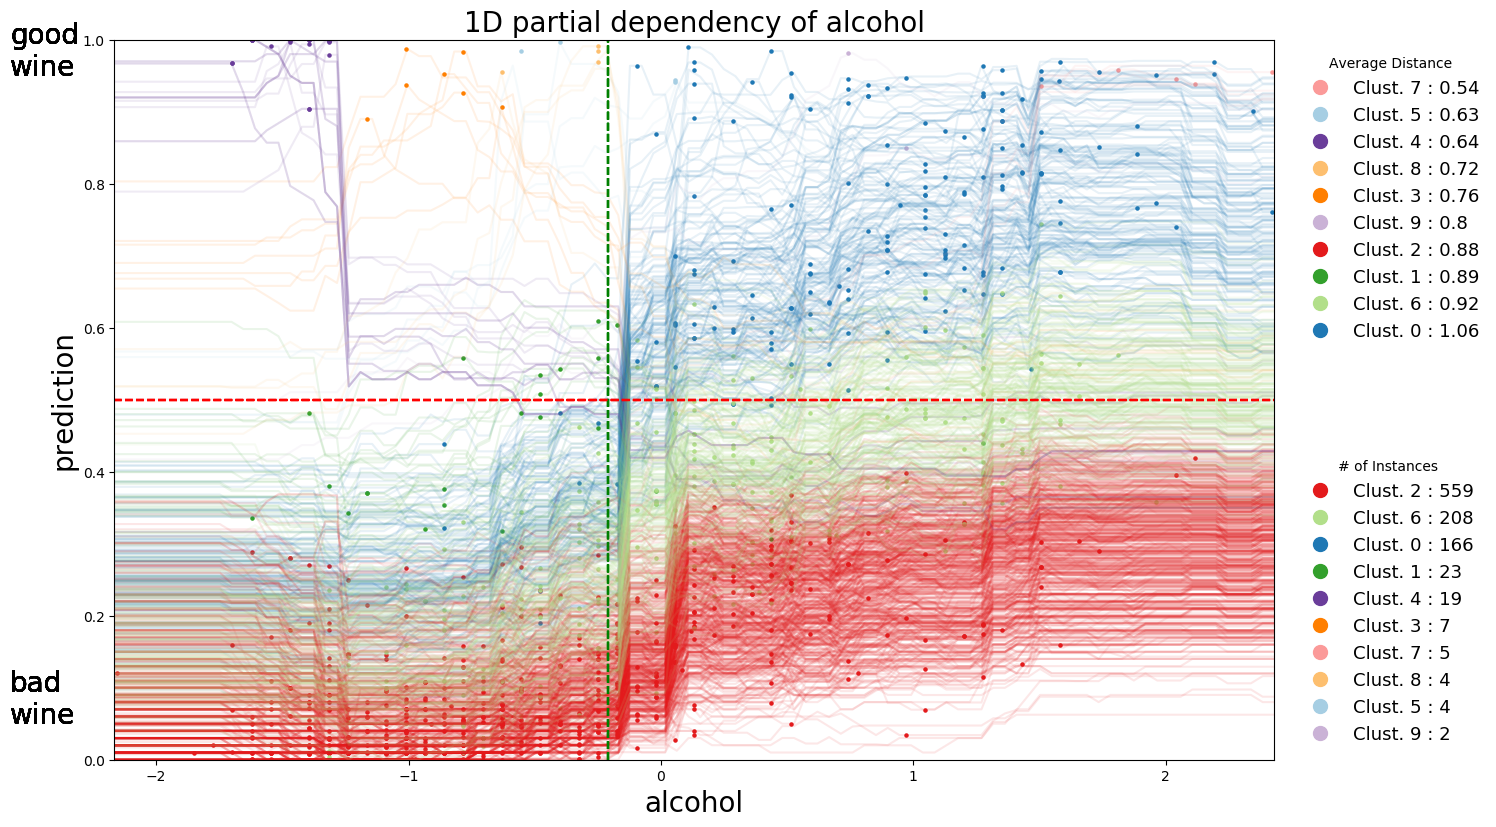

In [15]:
# initialization
wine_pdp_plot = pdp_plot.PartialDependence(normalized_df,
                                      model,
                                      labels_name,
                                      labels_focus)


# computing predictions for each of those different versions of vectors which vary the chosen_feature in the sample
curves = wine_pdp_plot.pdp(chosen_feature)

# this time we will use the DTW (LB Keogh) distance instead of the simple RMSE
curves.set_keogh_radius(wine_pdp_plot.get_optimal_keogh_radius())

# computing the clustering using the distances among the different prediction curves using DTW
# computing the distance matrix will be required only once and stored, 
# but it takes some time to compute, please wait a few minutes..
curves_list_keogh = wine_pdp_plot.compute_clusters(curves,ch_clust_number)

# plotting the data points instead of the edges for each wine: 
#each dot is: (original normalized alcohol, original prediction)
wine_pdp_plot.plot(curves_list_keogh, local_curves = False, plot_full_curves= True)

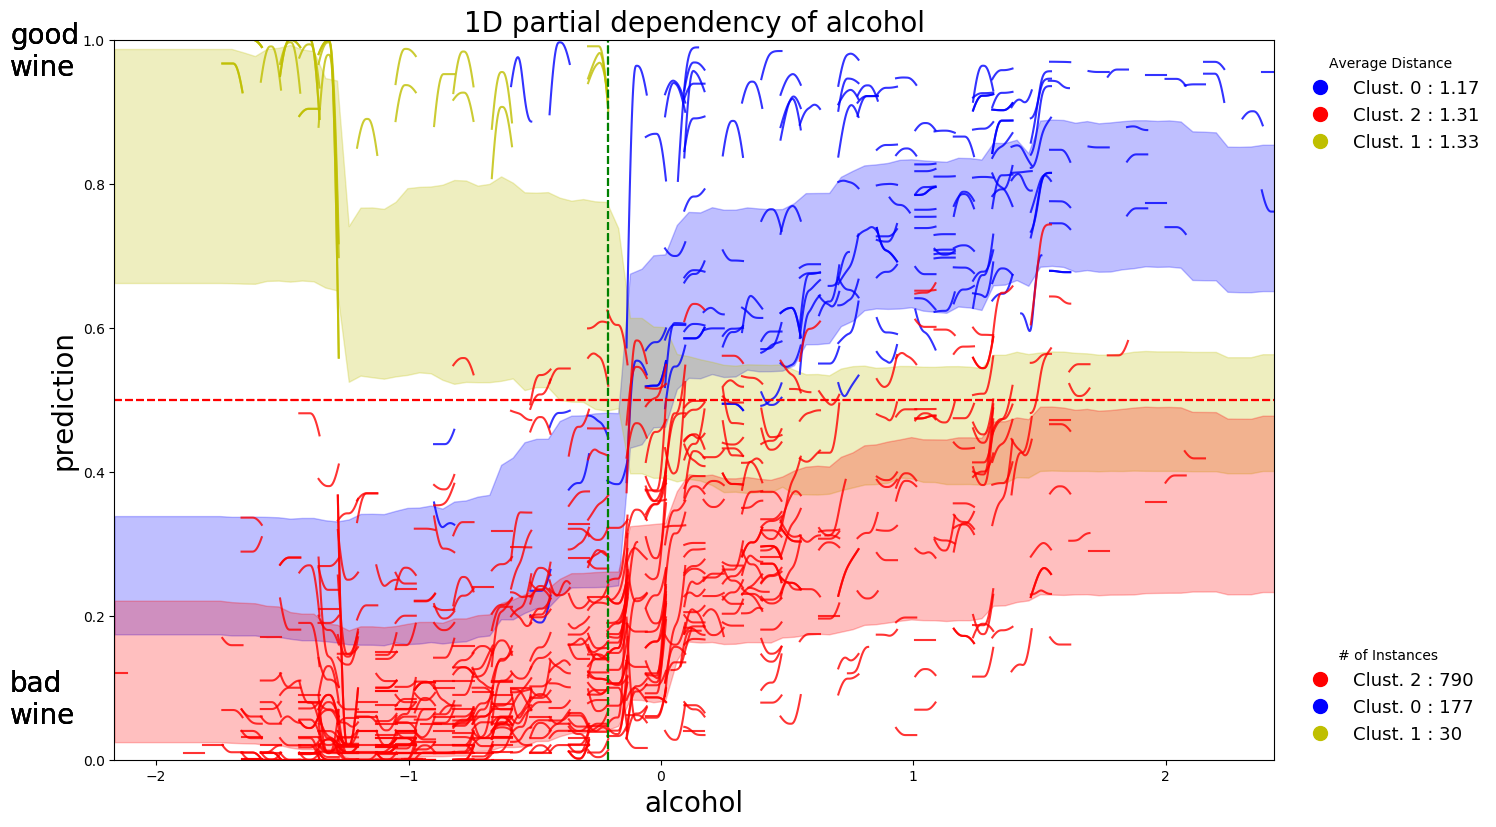

In [16]:
# changing number of clusters
curves_list_keogh = wine_pdp_plot.compute_clusters(curves,3)

wine_pdp_plot.plot(curves_list_keogh,
                   color_plot=["b","y","r"],
                   local_curves = True)

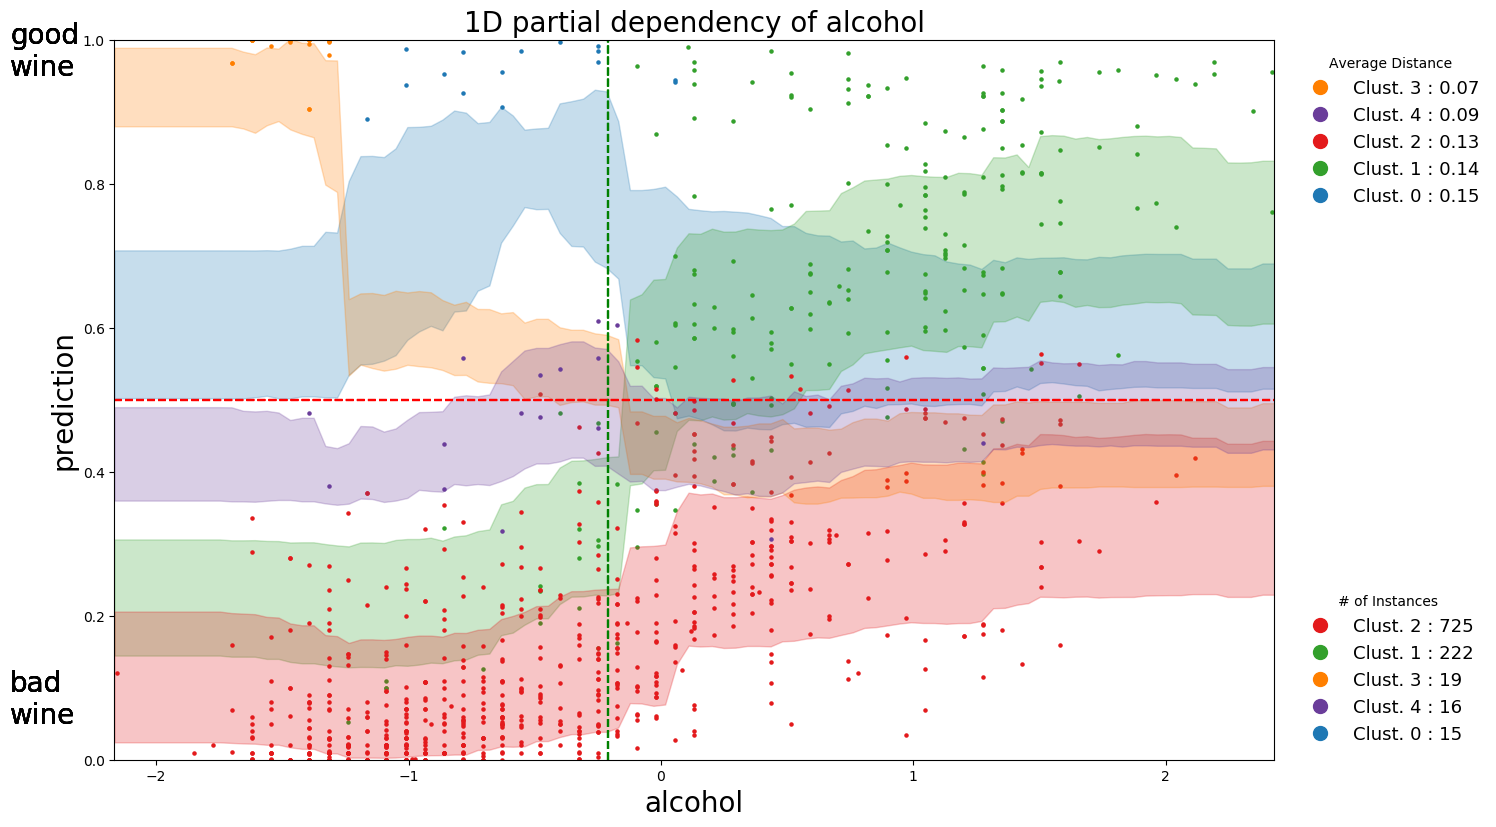

In [17]:
# trying again RMSE
curves.set_keogh_radius(None)

curves_list_RMSE = wine_pdp_plot.compute_clusters(curves,5)

wine_pdp_plot.plot(curves_list_RMSE,
                   local_curves = False)

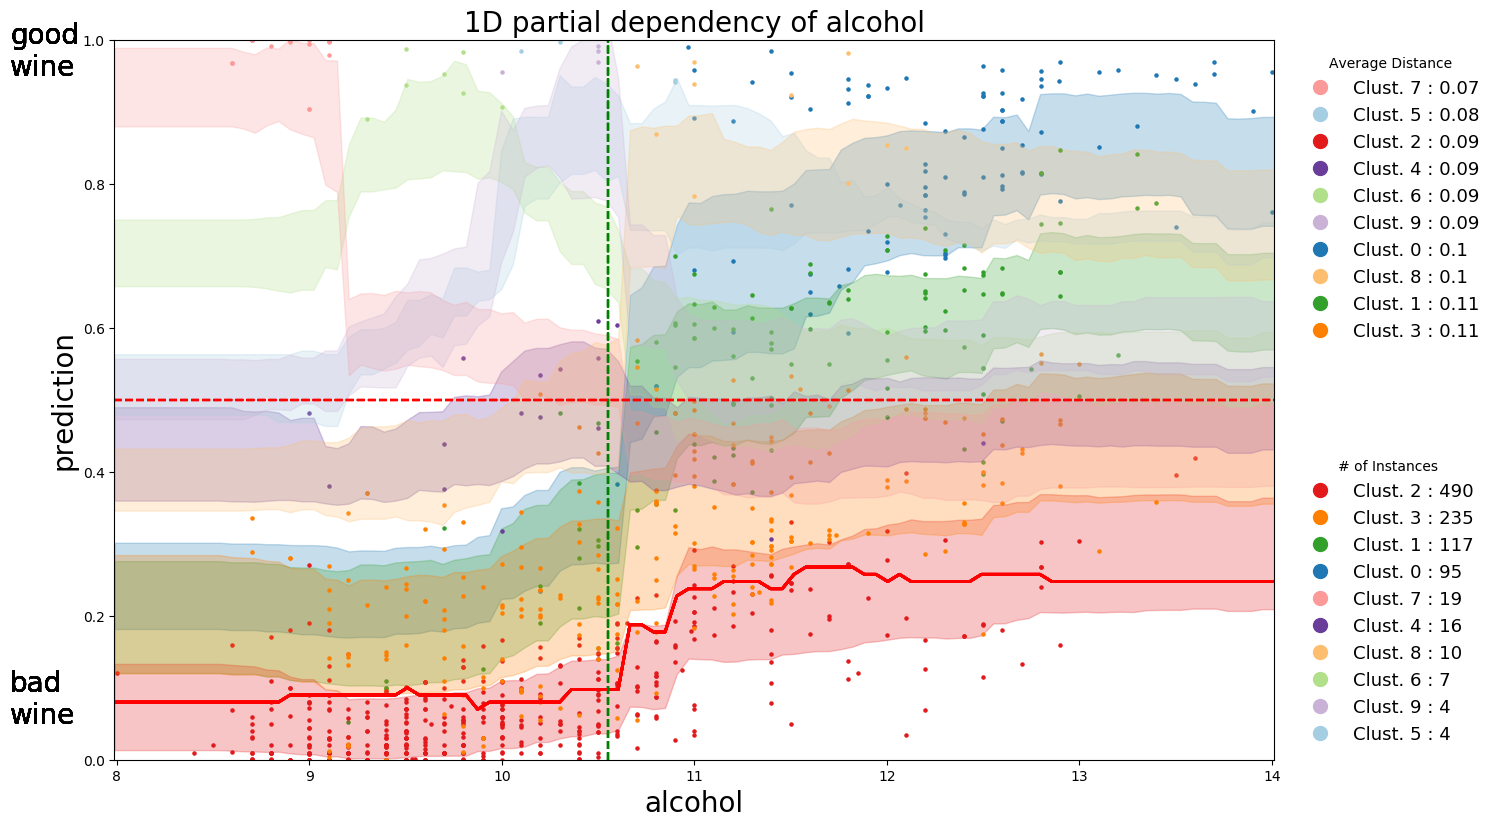

In [18]:
# initialization
wine_pdp_plot = pdp_plot.PartialDependence(df_test,
                  model,
                  labels_name,
                  labels_focus,
                  ch_num_samples,
                  ch_scale,
                  ch_shift)

# creating a custom_vector with all features equal to mean values 
# highlighing its partial dependence in red in the visualization
custom_vect = np.zeros(len(df_test.columns))
i = 0
for fix in df_test.columns:
    custom_vect[i] = np.mean(df_test[fix])
    i+= 1
    

curves, custom_preds = wine_pdp_plot.pdp(chosen_feature,chosen_row=custom_vect)

# computing the clustering using the distances among the different prediction curves
curves_list = wine_pdp_plot.compute_clusters(curves,ch_clust_number)

# plotting all we got
wine_pdp_plot.plot(curves_list,local_curves = False,
                   chosen_row_preds_to_plot=custom_preds)
